In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout,LeakyReLU, ELU, Flatten, AveragePooling2D, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.python.client import device_lib

print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_built_with_cuda() 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17614133316132426549
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5690953728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2273449233781484290
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


True

In [2]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


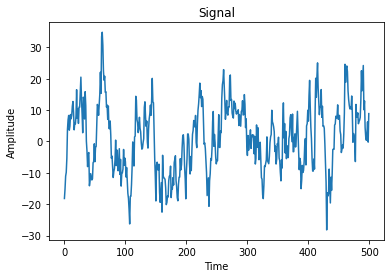

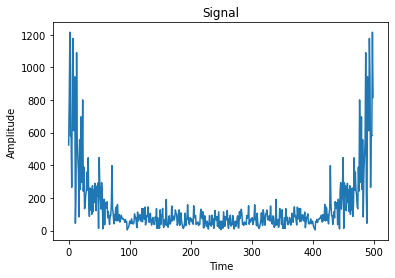

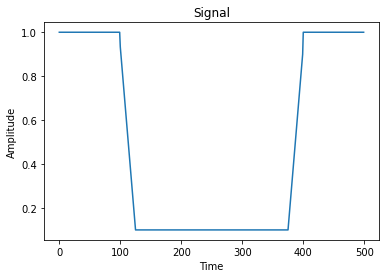

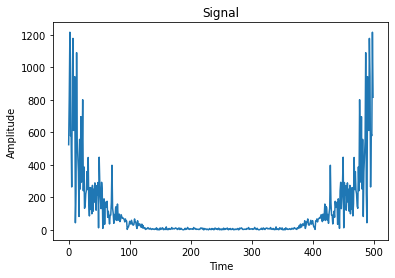

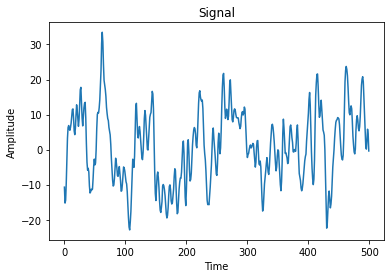

In [4]:
def data_crop(X):
    return X[:,:,0:500]

def data_augmentation(x):
    filter_x = np.zeros(x.shape)
    filter_low_pass = np.zeros(x.shape[2])
    for ii in range(500):
        if ii < 100:
            filter_low_pass[ii] = 1
        if ii >= 100 and ii < 125:
            filter_low_pass[ii] = (125 - ii)/30+0.1
        if ii >= 125 and ii < 375:
            filter_low_pass[ii] = 0.1
        if ii >= 375 and ii < 400:
            filter_low_pass[ii] = (-375 + ii)/30+0.1
        if ii >= 400 and ii < 500:           
            filter_low_pass[ii] = 1
    
    for ii in range(x.shape[0]):
        for jj in range(x.shape[1]):
            temp_x = x[ii,jj,:]
            fft_x = np.fft.fft(temp_x)
            fft_x_filter = fft_x*filter_low_pass
            filter_x[ii,jj,:] = np.real(np.fft.ifft(fft_x_filter))
    return filter_x
    
def data_augmentation_1(x,y):
    
    # block is defined to find the size of the block to apply average and max pooling 
    
    x_noise = x + np.random.normal(0.0, 0.5, x[:,:].shape)
    
    total_x = np.vstack((x, x_noise))
    total_y = np.vstack((y, y))
    print('the size of the total x:',total_x.shape)
    print('the size of the total y:',total_y.shape)
    
    
    return total_x,total_y

test_x = X_train_valid[2,10,0:500]

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), test_x, color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

fft_test_x = np.fft.fft(test_x)

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), np.abs(fft_test_x), color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

filter_low_pass = np.zeros(500)
for ii in range(500):
    if ii < 100:
        filter_low_pass[ii] = 1
    if ii >= 100 and ii < 125:
        filter_low_pass[ii] = (125 - ii)/30+0.1
    if ii >= 125 and ii < 375:
        filter_low_pass[ii] = 0.1
    if ii >= 375 and ii < 400:
        filter_low_pass[ii] = (-375 + ii)/30+0.1
    if ii >= 400 and ii < 500:           
        filter_low_pass[ii] = 1
       
        
fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), np.abs(filter_low_pass), color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()
        
fft_test_x_filter = fft_test_x * filter_low_pass
        
fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), np.abs(fft_test_x_filter), color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

test_filter_x = np.real(np.fft.ifft(fft_test_x_filter))

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), test_filter_x, color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

3


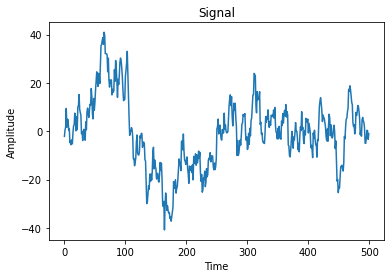

(2115, 22, 500, 1)


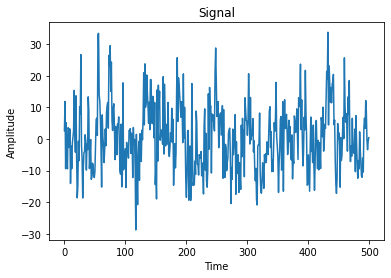

In [5]:
x_train = data_crop(X_train_valid)

# x_train = data_augmentation(x_train)

# x_train = np.vstack((x_train, x_train_filter))

x_train = x_train.reshape(2115, 22, 500, 1)
y_train = to_categorical((y_train_valid - 769), 4)
y_train = np.vstack((y_train, y_train))

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), x_train[1,5,:,0], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(y_train_valid[1]-769)

plt.show()

# generate a random permutation of indices
perm = np.random.permutation(len(x_train))

# shuffle the training data and labels using the permutation
x_train = x_train[perm]
y_train = y_train[perm]


fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), x_train[1,5,:,0], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(x_train.shape)

plt.show()

x_valid = x_train[1801:2114,:,:,:]
y_valid = y_train[1801:2114,:]

x_train = x_train[0:1800,:,:,:]
y_train = y_train[0:1800,:]


x_test = data_crop(X_test)
# x_test = data_augmentation(x_test)
x_test = x_test.reshape(443, 22, 500, 1)
y_test = to_categorical((y_test - 769), 4)

In [19]:
# Define an input layer for grayscale image
inputs = keras.Input(shape=(22,500,1), name="EEG")

x = keras.layers.Conv2D(filters=40, kernel_size=(1,25), activation=None, name='Temp-conv-side-1-2')(inputs)

x = tf.keras.layers.Permute((2,1,3), name = 'permute-0')(x)

x = tf.reshape(x,[-1,476,880])

x = tf.keras.layers.Dense(units=40)(x)

x = keras.layers.Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=L1L2(0,0), 
                      recurrent_regularizer=L1L2(0,0), name="LSTM-1"))(x)

x = tf.math.square(x, name='square layer')

x = tf.reshape(x,[-1,1,476,32])

x = keras.layers.AveragePooling2D(pool_size = (1, 75), strides = (1,15), name = 'Ave-Pool')(x)

x = tf.math.log(x, name='log layer')

x = keras.layers.Flatten()(x) 

class_probs = keras.layers.Dense(4, kernel_regularizer=L1L2(l1 = 0, l2 = 0), activation='softmax')(x) # Output FC layer with softmax activation

# now wrap the model inputs and outputs
model = keras.Model(inputs=inputs, outputs=class_probs, name="eeg_resnet")

model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8), metrics=[keras.metrics.categorical_accuracy])
    

# Printing the model summary
model.summary()

Model: "eeg_resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EEG (InputLayer)            [(None, 22, 500, 1)]      0         
                                                                 
 Temp-conv-side-1-2 (Conv2D)  (None, 22, 476, 40)      1040      
                                                                 
 permute-0 (Permute)         (None, 476, 22, 40)       0         
                                                                 
 tf.reshape_6 (TFOpLambda)   (None, 476, 880)          0         
                                                                 
 dense_6 (Dense)             (None, 476, 40)           35240     
                                                                 
 bidirectional_3 (Bidirectio  (None, 476, 32)          7296      
 nal)                                                            
                                                        

In [20]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime
from keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.optimizers import Adam

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 5, factor = 0.5)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# Model parameters
lr =5e-4
epochs = 50
opt = Adam(learning_rate=lr)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Training and validating the model
hybrid_cnn_lstm_model_results = model.fit(x_train,
             y_train,
             batch_size=50,
             epochs=epochs,
             callbacks=[tb_callback, lr_callback],                    
             validation_data=(x_valid, y_valid), verbose=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/50
36/36 [==============================] - 5s 97ms/step - loss: 1.5314 - accuracy: 0.3083 - val_loss: 1.4246 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 2/50
36/36 [==============================] - 3s 70ms/step - loss: 1.3168 - accuracy: 0.4033 - val_loss: 1.3502 - val_accuracy: 0.3355 - lr: 5.0000e-04
Epoch 3/50
36/36 [==============================] - 2s 69ms/step - loss: 1.2298 - accuracy: 0.4467 - val_loss: 1.2839 - val_accuracy: 0.3994 - lr: 5.0000e-04
Epoch 4/50
36/36 [==============================] - 2s 66ms/step - loss: 1.1922 - accuracy: 0.4744 - val_loss: 1.2460 - val_accuracy: 0.4249 - lr: 5.0000e-04
Epoch 5/50
36/36 [==============================] - 3s 75ms/step - loss: 1.1016 - accuracy: 0.5278 - val_loss: 1.2677 - val_accuracy: 0.4409 - lr: 5.0000e-04
Epoch 6/50
36/36 [==============================] - 3s 71ms/step - loss: 1.0462 - accuracy: 0.5667 - val_loss: 1.1689 - 

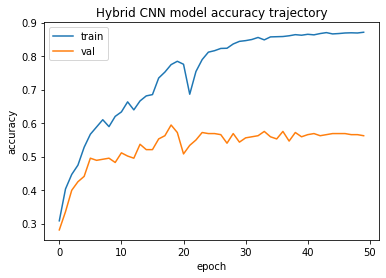

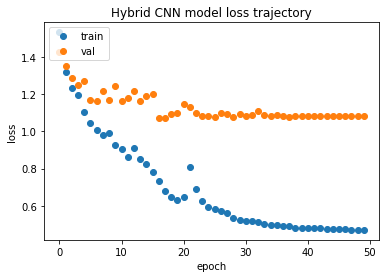

In [21]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
## Testing the hybrid CNN-LSTM model
# model = tf.keras.models.load_model('my_model')
hybrid_cnn_lstm_score = model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.5485327243804932


In [25]:

# Save the model weights
model.save_weights('C:\ECE C247\Final_project\project\BestModel_CNNLSTM\weights')

# Save the model architecture
with open('C:/ECE C247/Final_project/project/BestModel_CNNLSTM/architecture.json', 'w') as f:
    f.write(model.to_json())

In [26]:
# Load the model architecture
with open('C:/ECE C247/Final_project/project/BestModel_CNNLSTM/architecture.json', 'r') as f:
    model_architecture = f.read()

# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(model_architecture)

# Load the model weights
loaded_model.load_weights('C:\ECE C247\Final_project\project\BestModel_CNNLSTM\weights')
from tensorflow.keras.optimizers import Adam
# Compile the model
lr =5e-4
opt = Adam(learning_rate=lr)
loaded_model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

hybrid_cnn_lstm_score = loaded_model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid model: 0.5485327243804932
